In [1]:
import string
import numpy as np
# from PIL import Image
import cv2
import os
from pickle import dump, load
import matplotlib.pyplot as plt

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model,load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
import json


from keras.utils import plot_model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#the below function is for loading the required no of features.
#as we want to train using 1500 images k will be 1500
def load_features(k):
  features = load(open("/content/drive/MyDrive/Project_Neural_image_caption_gen/exp_folder/featurescv2_8000.p","rb"))
  fet={}
  count=1
  for i in features.keys():
    fet[i]=features[i]
    if count==k:
      return fet
    count+=1
# fet=load_features(1500)
# print(fet)
# print(len(fet))

In [ ]:
def extract_features(directory):
        model = Xception(include_top=False, pooling='avg' )
        features = {}
        count=0
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            # image = Image.open(filename)
            # print(image2.img)
            image=cv2.imread(filename)
            # print(image.shape)
            # print(image.shape)
            # image = image.resize((299,299))

            image = np.expand_dims(image, axis=0)
            # image = preprocess_input(image)
            # image = image/127.5
            # image = image - 1.0
            
            feature = model.predict(image)
            # print(feature.shape)
            # print(feature)
            # feature=feature[0][:]
            features[img] = feature
            # print(feature.shape)
            # print(feature)
            # count+=1
            # if (count==7000):
            #   break
        return features
features = extract_features('/content/drive/MyDrive/Project_Neural_image_caption_gen/Flickr8k_Dataset/Flicker8k_Dataset')
dump(features, open("/content/drive/MyDrive/Project_Neural_image_caption_gen/exp_folder/featurescv2_8000.p","wb"))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [4]:

features = load_features(1500)
# out = dict(list(features.items())[0: 10]) 
# print(out)
# print(features)
# print(len(features))

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


#we give text file as input and we get captions dictionary as output.
def descriptions_traindata(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] in features.keys():
          if img[:-2] not in descriptions:
              descriptions[img[:-2]] = [caption]
          else:
              descriptions[img[:-2]].append(caption)
    # out = dict(list(descriptions.items())[0: 10])  
    # print(out)
    # print(len(descriptions),"all images")
    return descriptions


#returns dictionary with imagename as key and their captions as values converts captions to lower with removing of extra puncuation marks
def captions_dic_td(filename):
    captions=descriptions_traindata(filename)
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    # out = dict(list(captions.items())[0: 10])  
    # print(json.dumps(out,indent=4))
    return captions





In [ ]:
# my_set = {1, 2, 3}
# for i in my_set:
#   print(i)

1
2
3


In [5]:

#below is passed with captions preprocessed without start and end


#creating tokenizer class which maps each word in vocabulary to unique key
#this will vectorise text corpus
#each integer will represent token in dictionary
def preprocess(txt):
  desc = 'start ' + txt + ' end'
  return desc

# In the below function entire preprocessing takes place along with appending of <start> and <end> to the caption
def load_clean_descriptions(filename):   
    #loading clean_descriptions
    temp = captions_dic_td(filename)
    

    for k,v in temp.items():
      for vv in v:

        temp[k][v.index(vv)]=preprocess(vv)
        
    # out = dict(list(temp.items())[0: 10])  
    # print(json.dumps(out,indent=4))

    return temp

# gives the vocabulary
def text_vocabulary(filename):
    # build vocabulary of all unique words
    descriptions=load_clean_descriptions(filename)

    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    # print(len(vocab))
    tokenized={}
    count=0
    for i in vocab:
      count+=1
      tokenized[i]=count

    return tokenized

vocab=text_vocabulary('/content/drive/MyDrive/Project_Neural_image_caption_gen/Flickr8k_text/Flickr8k.token.txt')
dump(vocab, open("/content/drive/MyDrive/Project_Neural_image_caption_gen/vocab.p","wb"))
# print(vocab)
# print(vocab['start'])
caption=load_clean_descriptions('/content/drive/MyDrive/Project_Neural_image_caption_gen/Flickr8k_text/Flickr8k.token.txt')
dump(caption, open("/content/drive/MyDrive/Project_Neural_image_caption_gen/caption.p","wb"))
print(len(caption))

# out = dict(list(caption.items())[0: 10])  
# print(json.dumps(out,indent=4))
def caption_to_encoded(filename):
    #loading clean_descriptions
    caption =load_clean_descriptions(filename)
    

    for k,v in caption.items():
      for vv in v:
        encoded=[]
        for word in vv.split():
          encoded.append(vocab[word])
        caption[k][v.index(vv)]=encoded
    # out = dict(list(caption.items())[0: 10])  
    # print(json.dumps(out,indent=4))
    return caption
encoded_captions=caption_to_encoded('/content/drive/MyDrive/Project_Neural_image_caption_gen/Flickr8k_text/Flickr8k.token.txt')
dump(encoded_captions, open("/content/drive/MyDrive/Project_Neural_image_caption_gen/encoded_captions.p","wb"))


1500


In [5]:
import string
import numpy as np
import os
from pickle import dump, load
import matplotlib.pyplot as plt

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
import json


from keras.utils import plot_model
from keras.models import Sequential
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm

encoded_captions = load(open("/content/drive/MyDrive/Project_Neural_image_caption_gen/encoded_captions.p","rb"))
caption = load(open("/content/drive/MyDrive/Project_Neural_image_caption_gen/caption.p","rb"))
vocab = load(open("/content/drive/MyDrive/Project_Neural_image_caption_gen/vocab.p","rb"))

def maxlen(caption):
  maxval=-1

  for k, vv in caption.items():
    for v in vv:
       
        if len(v) > maxval:
            maxval = len(v)

  return maxval
MAX_LEN=maxlen(encoded_captions)
print(MAX_LEN)
print(len(vocab))
VOCAB_SIZE = len(vocab)+1
vocab_size=VOCAB_SIZE

# out = dict(list(features.items())[0: 10]) 
# print(out)


def generator(photos,descriptions,max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0

    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            # photo = photos[key+'.jpg']
            for seq in desc_list:

                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    # print(photos[key][0].shape)
                    X1.append(photos[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n=0

# features = load_features(1500)
# # x = np.array(x)
# # yin = np.array(yin)
# # yout = np.array(yout)
# print(fet.shape,yin.shape,yout.shape)

34
3971


In [2]:

def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics='accuracy')
    # summarize model
    model.summary()
    # plot_model(model, to_file='model.png', show_shapes=True)
    return model
model=define_model(len(vocab)+1,34)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1016832     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

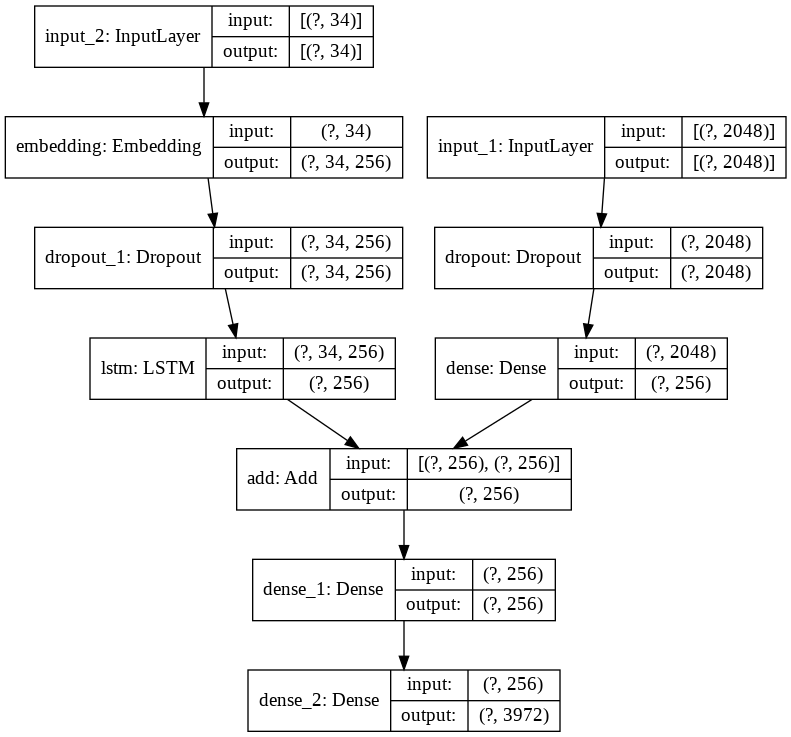

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
spe=1500
epochs=20
# up to 39 epochs batch size of 70
# after 39 epochs batch size is 130
# after 39 epochs batch size 200

features = load_features(1500)
model=load_model('/content/drive/MyDrive/Project_Neural_image_caption_gen/myfeatures/weights150038.h5')
for i in range(epochs):
      gen =generator(features,encoded_captions,MAX_LEN,200)
      model.fit_generator(gen,steps_per_epoch=spe,verbose=1)
      model.save('/content/drive/MyDrive/Project_Neural_image_caption_gen/myfeatures/weights1500_200_'+str(i)+'.h5')
      


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1090/1500 [====================>.........] - ETA: 5:47 - loss: 0.3651 - accuracy: 0.8758

In [ ]:
# model.save('/content/drive/MyDrive/Project_Neural_image_caption_gen/exp_folder/weights.h5')

NameError: ignored

In [7]:
inv_dict={v:k for k,v in vocab.items()}

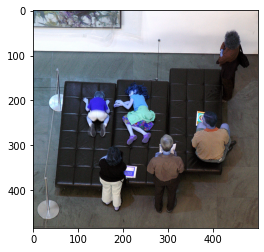

start two tired children rest on couches at an art museum while the adults around them view the art end


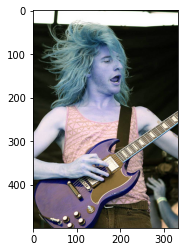

start man rocks out onstage with his guitar end


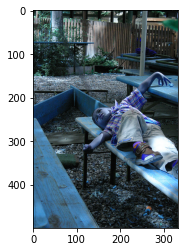

start little boy lies down on picnic table bench end


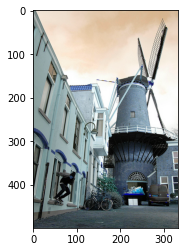

start guy grinds windowsill near an old windmill end


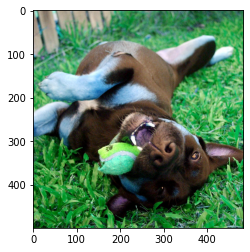

start the woman wearing blue shirt sits in front of brick wall end


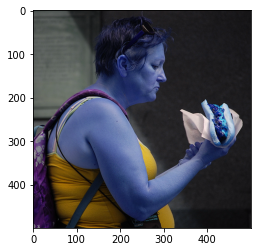

start fat woman wearing blue tank top and backpack eating chili cheese dog end


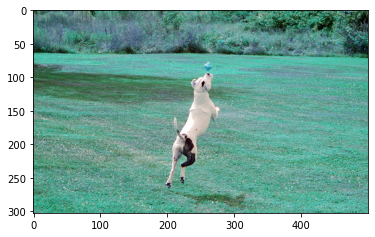

start dog leaps to catch ball in field end


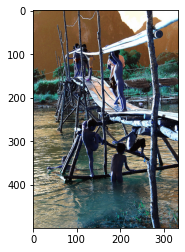

start there are naked children playing on wood bridge end


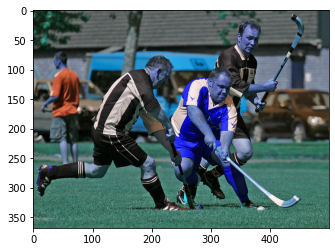

start lone red team player breaks through two black team players to hit the ball end


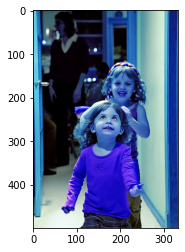

start two sisters race through the hallways in the house end


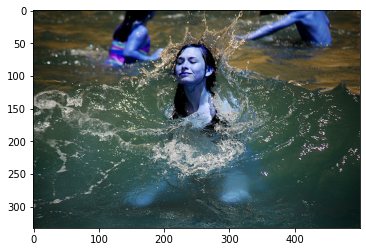

start girl is being splashed by an ocean wave end


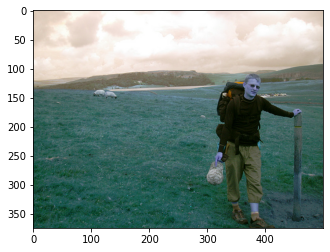

start man in jeans is playing with ball while woman in jeans stands nearby looking away end


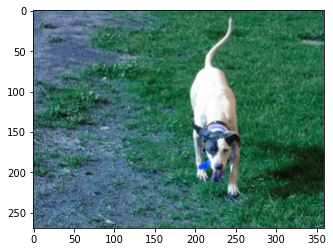

start dog running with his tongue out end


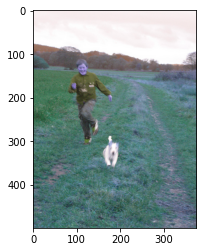

start small boy holding is arm out to balance himself while he goes down the fairground slide end


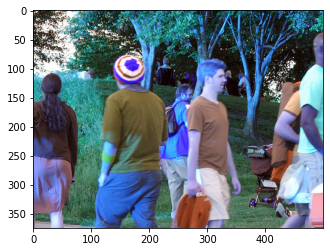

start pedestrians walk on sidewalk next to grassy wooded field end


In [15]:
import cv2
# encoded_captions = load(open("/content/drive/MyDrive/Project_Neural_image_caption_gen/encoded_captions.p","rb"))
# caption = load(open("/content/drive/MyDrive/Project_Neural_image_caption_gen/caption.p","rb"))
# vocab = load(open("/content/drive/MyDrive/Project_Neural_image_caption_gen/vocab.p","rb"))

# def maxlen(caption):
#   maxval=-1

#   for k, vv in caption.items():
#     for v in vv:
       
#         if len(v) > maxval:
#             maxval = len(v)

#   return maxval
# MAX_LEN=maxlen(encoded_captions)
# print(MAX_LEN)
# print(len(vocab))
# VOCAB_SIZE = len(vocab)+1
# vocab_size=VOCAB_SIZE


directory='/content/drive/MyDrive/Project_Neural_image_caption_gen/Flickr8k_Dataset/Flicker8k_Dataset'
features = load(open("/content/drive/MyDrive/Project_Neural_image_caption_gen/exp_folder/featurescv2_8000.p","rb"))
model=load_model('/content/drive/MyDrive/Project_Neural_image_caption_gen/myfeatures/weights1500_200_6.h5')
cou=0

inv_dict={v:k for k,v in vocab.items()}

for img in os.listdir(directory):
    
    if img in encoded_captions.keys():
      continue
    else:
      filename = directory + "/" + img
      # image = Image.open(filename)
      # test_img = image.resize((299,299))
      # test_img = np.expand_dims(test_img, axis=0)
      # test_img = test_img/127.5
      # test_img= test_img - 1.0
      image=cv2.imread(filename)
      # test_img = np.expand_dims(image, axis=0)
      # test_feature = modele.predict(test_img)
      # print(features[img].shape)
      # print(features[img])
      test_feature=features[img]
      # print(test_feature)
      # print(test_feature.shape)

      text_inp = ['start']

      count = 0
      res = 'start'
      while count < 34:
          count += 1

          encoded = []
          for i in text_inp:
              encoded.append(vocab[i])

          encoded = [encoded]

          encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


          prediction = np.argmax(model.predict([test_feature, encoded]))

          sampled_word = inv_dict[prediction]

          res = res + ' ' + sampled_word
              
          if sampled_word == 'end':
              break

          text_inp.append(sampled_word)
      
      # plt.figure()
      plt.imshow(image)
      plt.show()
      print(res)
      cou+=1
    if cou==15:
        break

In [ ]:
def nextSquare():  
    i = 1;  
  
    # An Infinite loop to generate squares  
    while True:  
        yield i*i                  
        i += 1 # Next execution resumes  
                # from this point      
  
# Driver code  
for num in nextSquare():  
    if num > 100:  
        break    
    print(num)  
# print(nextSquare())

1
4
9
16
25
36
49
64
81
100
